<a href="https://colab.research.google.com/github/ArifRezaKhan/pythonDS/blob/master/Hugging_Face_Course_Chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Under the Hood: The Pipeline Abstraction
The pipeline abstraction groups together three steps: preprocessing, passing the inputs through the model, and postprocessing.

en_chapter2_full_nlp_pipeline.svg

## Preprocessing with a tokenizer
Like other neural networks, Transformer models can’t process raw text directly, so the first step of our pipeline is to convert the text inputs into numbers that the model can make sense of. To do this we use a tokenizer, which will be responsible for:

- Splitting the input into words, subwords, or symbols (like punctuation) that are called tokens
- Mapping each token to an integer
- Adding additional inputs that may be useful to the model

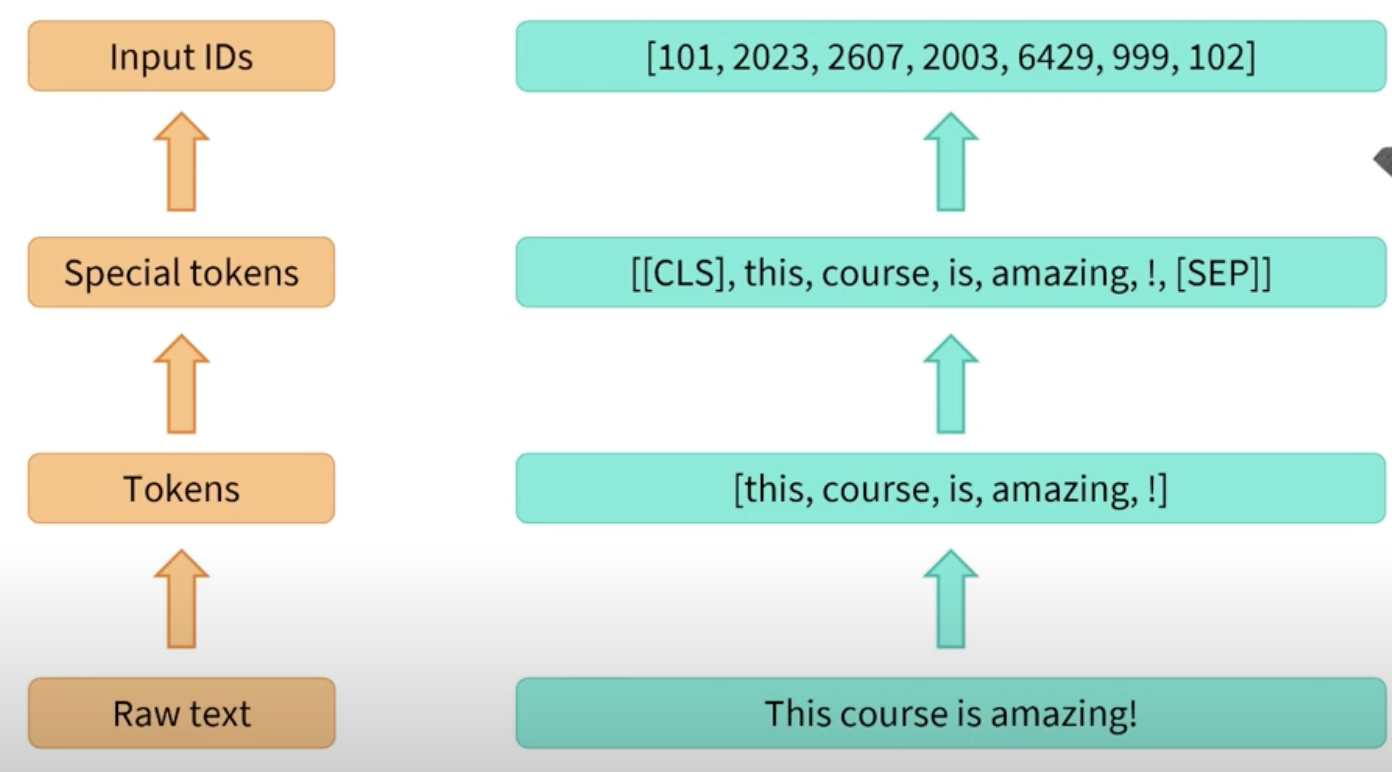


*All this preprocessing needs to be done in exactly the same way as when the model was pretrained, so we first need to download that information from the Model Hub. To do this, we use the `AutoTokenizer` class and its `from_pretrained()` method.*

``` python
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
```

The AutoTokenizer class can load the tokenizer for any checkpoint.

``` python
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)
```
This yields the output:

``` python
{
    'input_ids': tensor([
        [  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172, 2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,     0,     0,     0,     0,     0,     0]
    ]),
    'attention_mask': tensor([
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    ])
}
```

`attention_mask` indicates where padding has been applied.

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, return_tensors="pt")
print(inputs)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}


## Going through the model
We can download our pretrained model the same way we did with our tokenizer. Transformers library provides an `AutoModel` class which also has a `from_pretrained()` method:

```python
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)
```

`AutoModel` will download and cache the architecture, configuration and weights of the model.

**For each model input, we’ll retrieve a high-dimensional vector representing the contextual understanding of that input by the Transformer model**, called the hidden states, or features.

While these hidden states can be useful on their own, they’re usually inputs to another part of the model, known as the ***head***.

The features vector output by the Transformer model is usually large. It generally has three dimensions:

- Batch size: The number of sequences processed at a time (2 in our example).
- Max Sequence length: The length of the numerical representation of the longest sequence (16 in our example). (Others will be padded)
- Hidden size: The vector dimension of each model input.

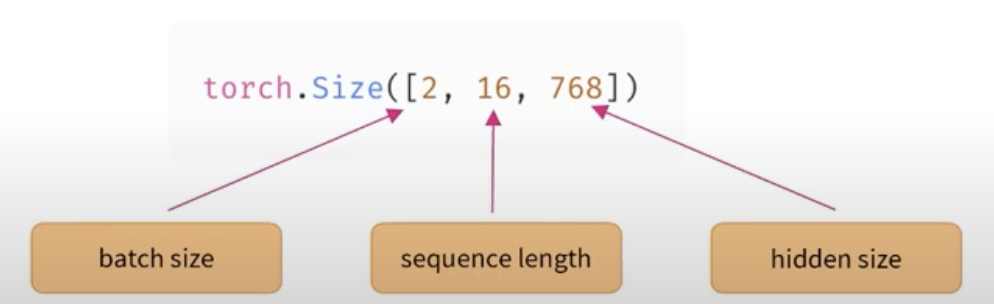

```python
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)
```
```python
torch.Size([2, 16, 768])
```

### What is the Model head?

The output of the Transformer model is sent directly to the model head to be processed.

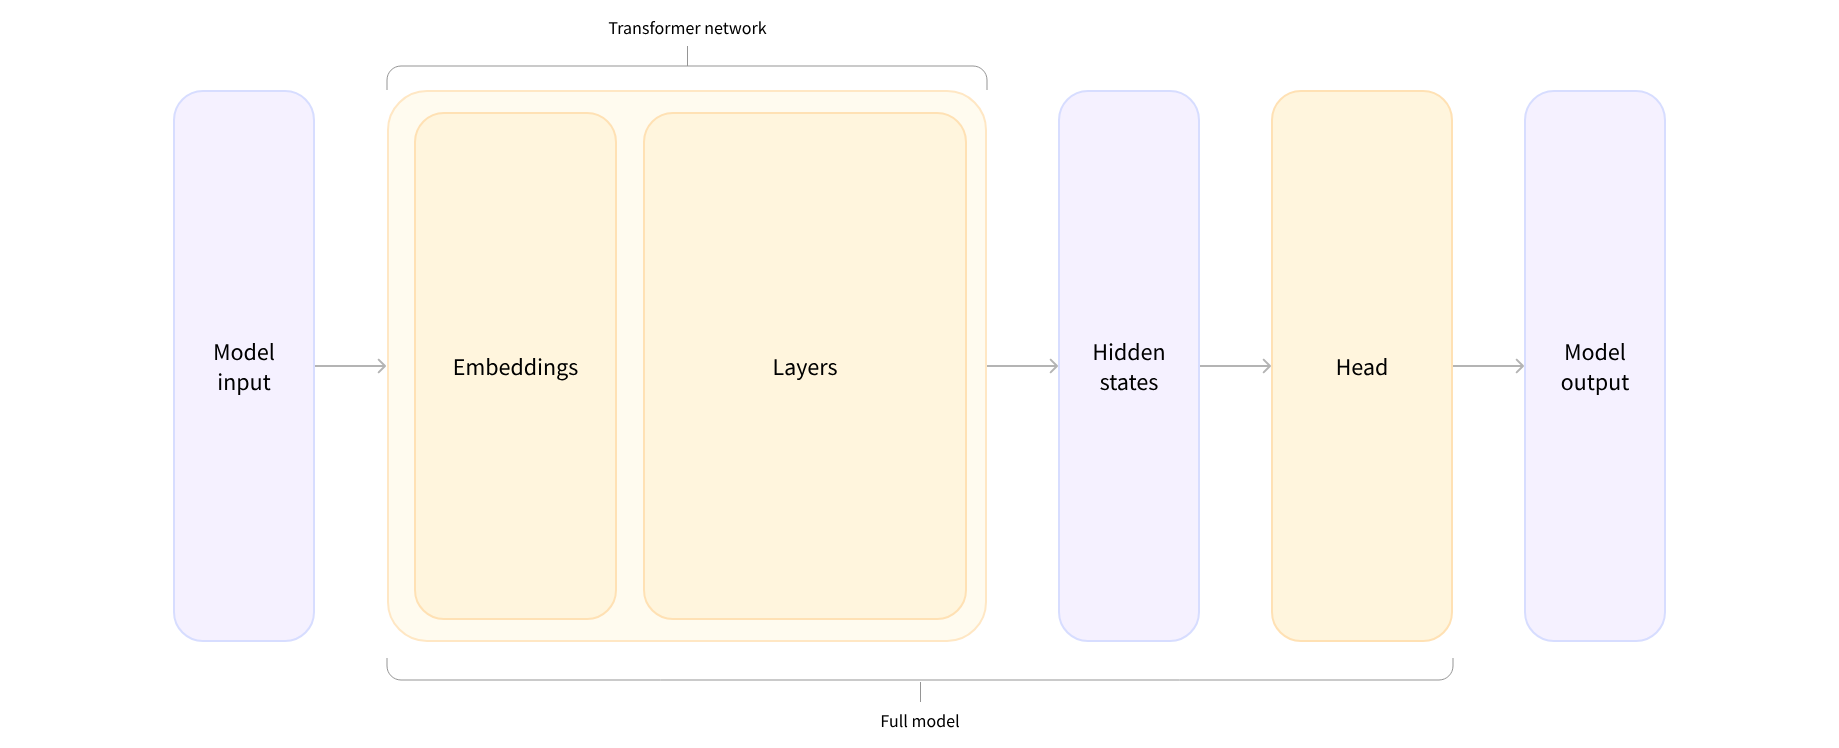

There are many different model architectures available in Transformers, with each one designed around tackling a specific task. Here is a non-exhaustive list:

* ForCausalLM
* ForMaskedLM
* ForMultipleChoice
* ForQuestionAnswering
* ForSequenceClassification
* ForTokenClassification

For our example, we will need a model with a sequence classification head (to be able to classify the sentences as positive or negative). So, we won’t actually use the AutoModel class, but `AutoModelForSequenceClassification`:

In [ ]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)
print(outputs.logits.shape)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

torch.Size([2, 2])


Since we have just two sentences and two labels, the result we get from our model is of shape 2 x 2.

## Postprocessing the output
The values we get as output from our model don’t necessarily make sense by themselves. Let’s take a look:

In [ ]:
print(outputs)

SequenceClassifierOutput(loss=None, logits=tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [ ]:
print(outputs.logits)

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)


Our model predicted `[-1.5607, 1.6123]` for the first sentence and `[ 4.1692, -3.3464]` for the second one. Those are not probabilities but logits, the raw, unnormalized scores outputted by the last layer of the model. To be converted to probabilities, they need to go through a SoftMax layer.

In [ ]:
import torch
torch.set_printoptions(sci_mode=False)

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

tensor([[    0.0402,     0.9598],
        [    0.9995,     0.0005]], grad_fn=<SoftmaxBackward0>)


Now we can see that the model predicted `[0.0402, 0.9598]` for the first sentence and `[0.9995, 0.0005]` for the second one. These are recognizable probability scores.
To get the labels corresponding to each position, we can inspect the id2label attribute of the model config:

In [ ]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

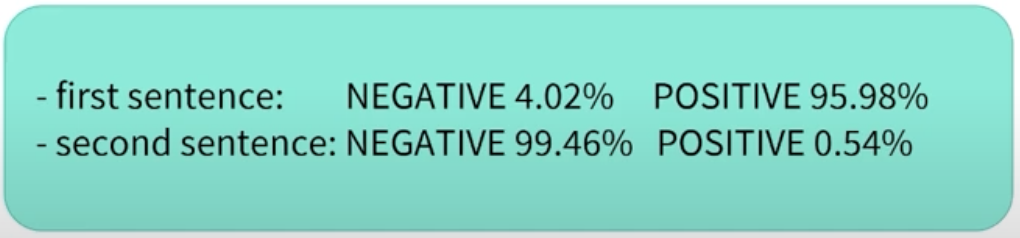

# Instantiate a Transformers Model

The `AutoModel` class and all of its relatives are actually simple wrappers over the wide variety of models available in the library. It’s a clever wrapper as it can automatically guess the appropriate model architecture for your checkpoint, and then instantiates a model with this architecture.

However, if you know the type of model you want to use, you can use the class that defines its architecture directly.

Loading a Transformer model that is already trained is simple — we can do this using the `from_pretrained()` method:

In [ ]:
from transformers import BertModel

model = BertModel.from_pretrained("bert-base-cased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

**This model is initialized with all the weights of the checkpoint. It can be used directly for inference on the tasks it was trained on, and it can also be fine-tuned on a new task. By training with pretrained weights rather than from scratch, we can quickly achieve good results.**

Creating a model from the default configuration initializes it with random values:

In [ ]:
from transformers import BertConfig, BertModel

# Building the config
config = BertConfig()

# Building the model from the config
model = BertModel(config)

In [ ]:
# The configuration contains many attributes that are used to build the model:
print(config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.41.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



**The model can be used in this state, but it will output gibberish; it needs to be trained first. We could train the model from scratch on the task at hand, but, this would require a long time and a lot of data, and it would have a non-negligible environmental impact.**

# Tokenizers

Tokenizers are one of the core components of the NLP pipeline. They serve one purpose: to translate text into data that can be processed by the model. Models can only process numbers, so tokenizers need to convert our text inputs to numerical data.

The goal is to find the most meaningful representation — that is, represent numbers that makes the most sense to the model — and, if possible, the smallest representation.

There are several ways to perform this conversion. Let's look at a few.
- Word-Based
- Character-Based
- Subword-Based

## Word-Based Tokenizers
It’s generally very easy to set up and use with only a few rules, and it often yields decent results. For example, in the image below, the goal is to split the raw text into words and find a numerical representation for each of them:

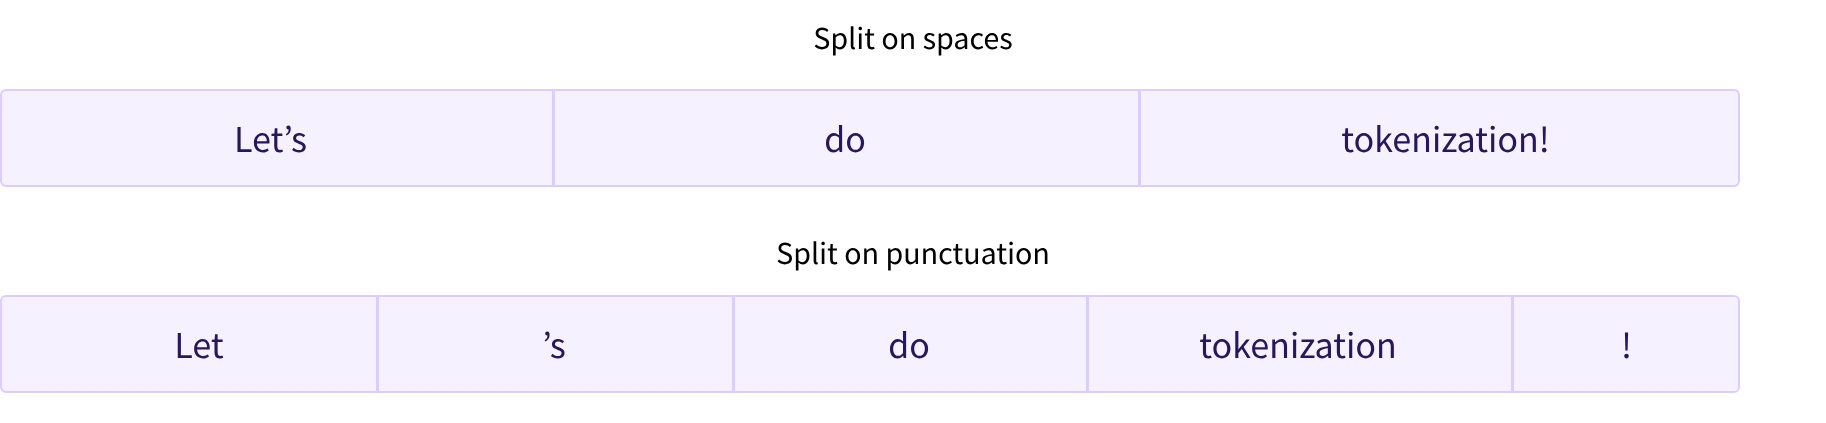

In [ ]:
vocabulary = "Jim Henson was a puppeteer".split()
print(vocabulary)

['Jim', 'Henson', 'was', 'a', 'puppeteer']


With this kind of tokenizer, we can end up with some pretty large “vocabularies,” where a vocabulary is defined by the total number of independent tokens that we have in our corpus.

Each word gets assigned an ID, starting from 0 and going up to the size of the vocabulary. The model uses these IDs to identify each word.

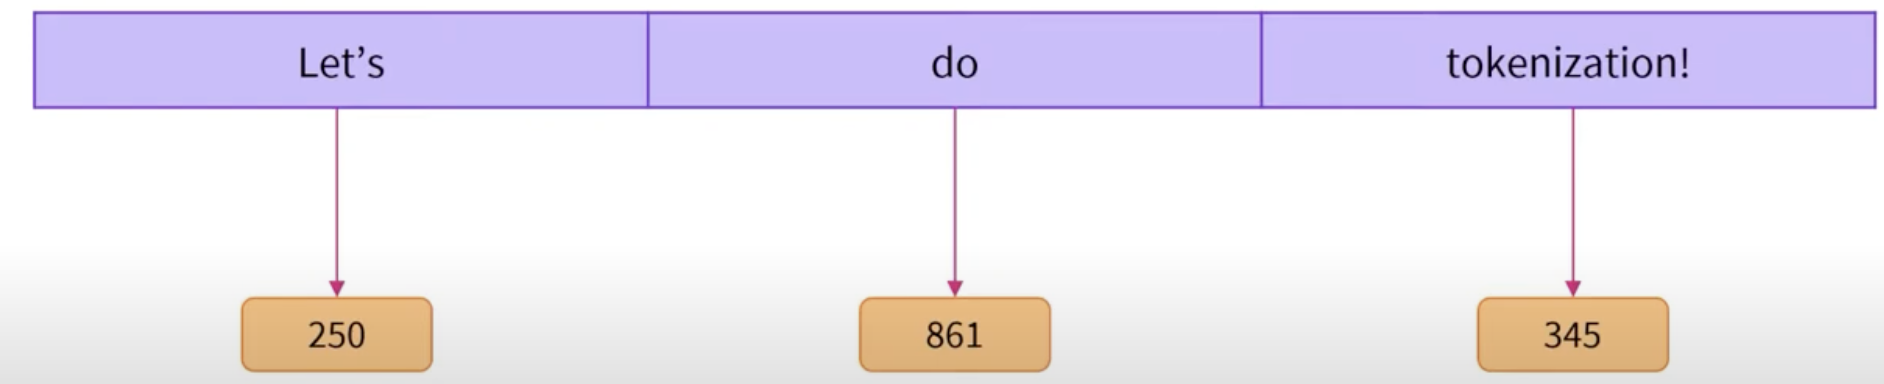

If we want to completely cover a language with a word-based tokenizer, we’ll need to have an identifier for each word in the language, which will generate a huge amount of tokens.



However, **large vocabularies end in very heavy models.**

For example, there are over **500,000 words** in the English language, so to build a map from each word to an input ID we’d need to keep track of that many IDs.

Furthermore, words like “dog” are represented differently from words like “dogs”, and the model will initially have no way of knowing that “dog” and “dogs” are similar: it will identify the two words as unrelated. The same applies to other similar words, like “run” and “running”, which the model will not see as being similar initially.

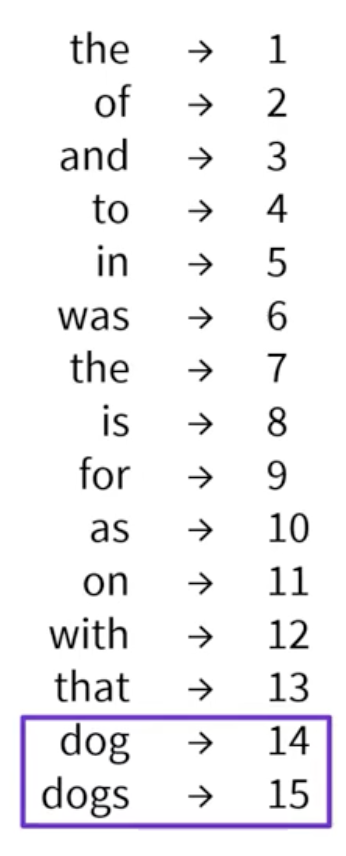

We can limit the amount of words we add to our vocabulary to (say) most common 10,000 words.

But, now we need a custom token to represent words that are not in our vocabulary. This is known as the “unknown” token, often represented as ”[UNK]” or ”<unk>”.

It’s generally a bad sign if you see that the tokenizer is producing a lot of these tokens, as it wasn’t able to retrieve a sensible representation of a word and you’re losing information along the way.

The goal when crafting the vocabulary is to do it in such a way that the tokenizer tokenizes as few words as possible into the unknown token.



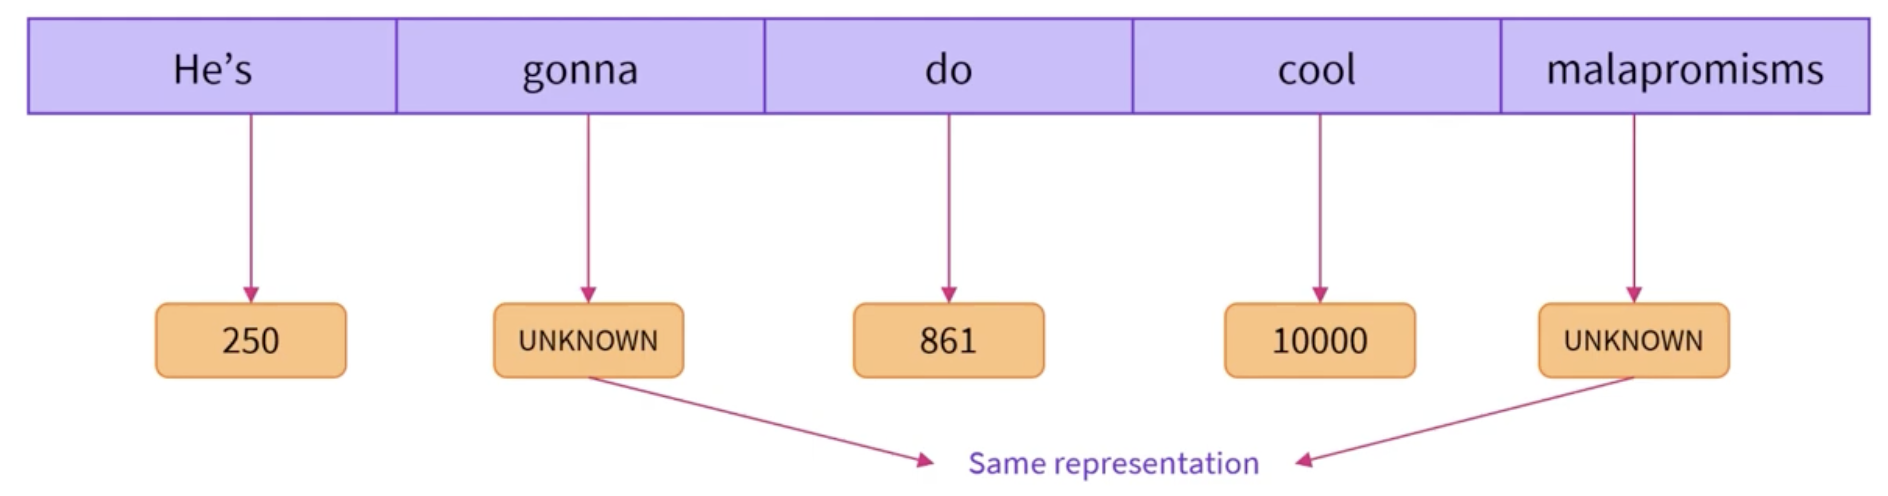

## Character-Based Tokenizers



Split text into individual characters:

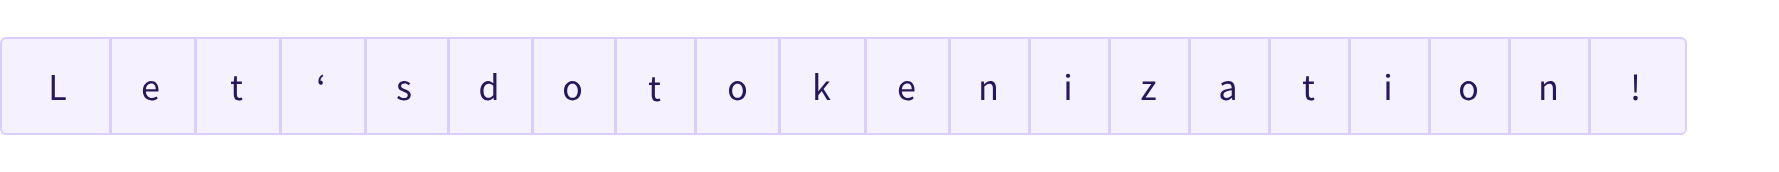

Character-based tokenizers split the text into characters, rather than words. This has two primary benefits:

- The vocabulary is much smaller.


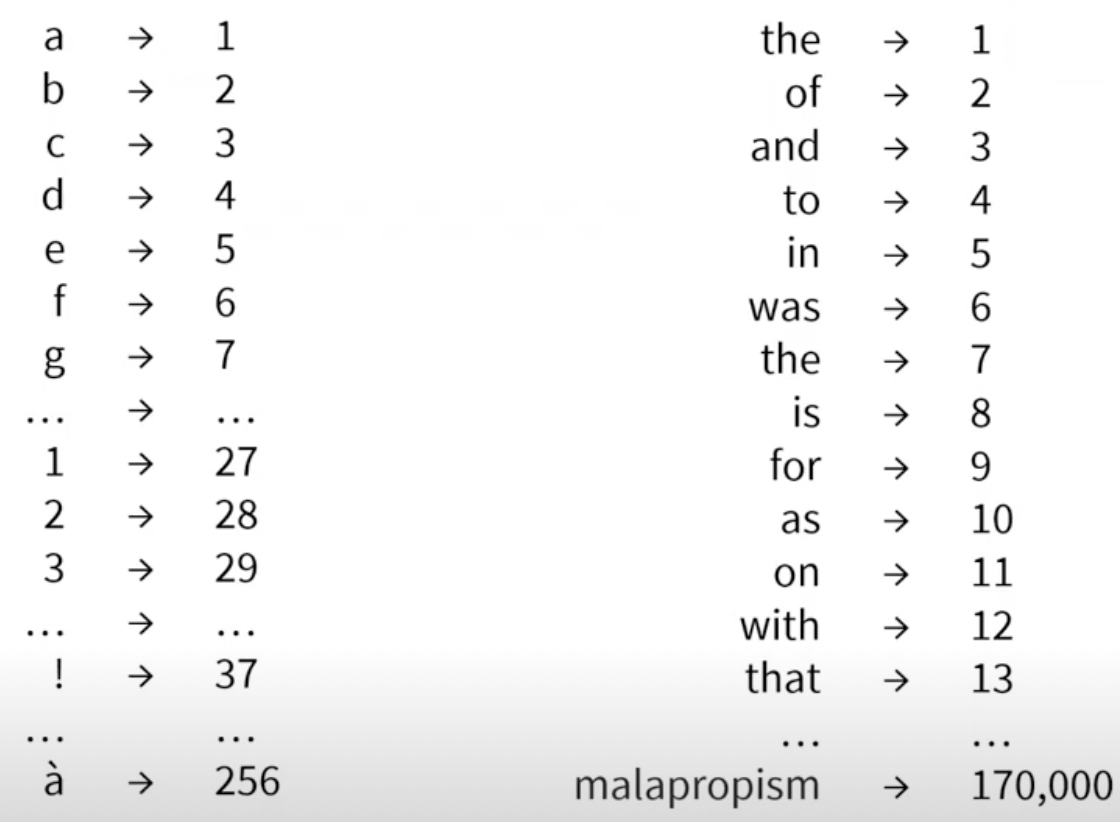

- There are much fewer out-of-vocabulary (unknown) tokens, since every word can be built from characters.

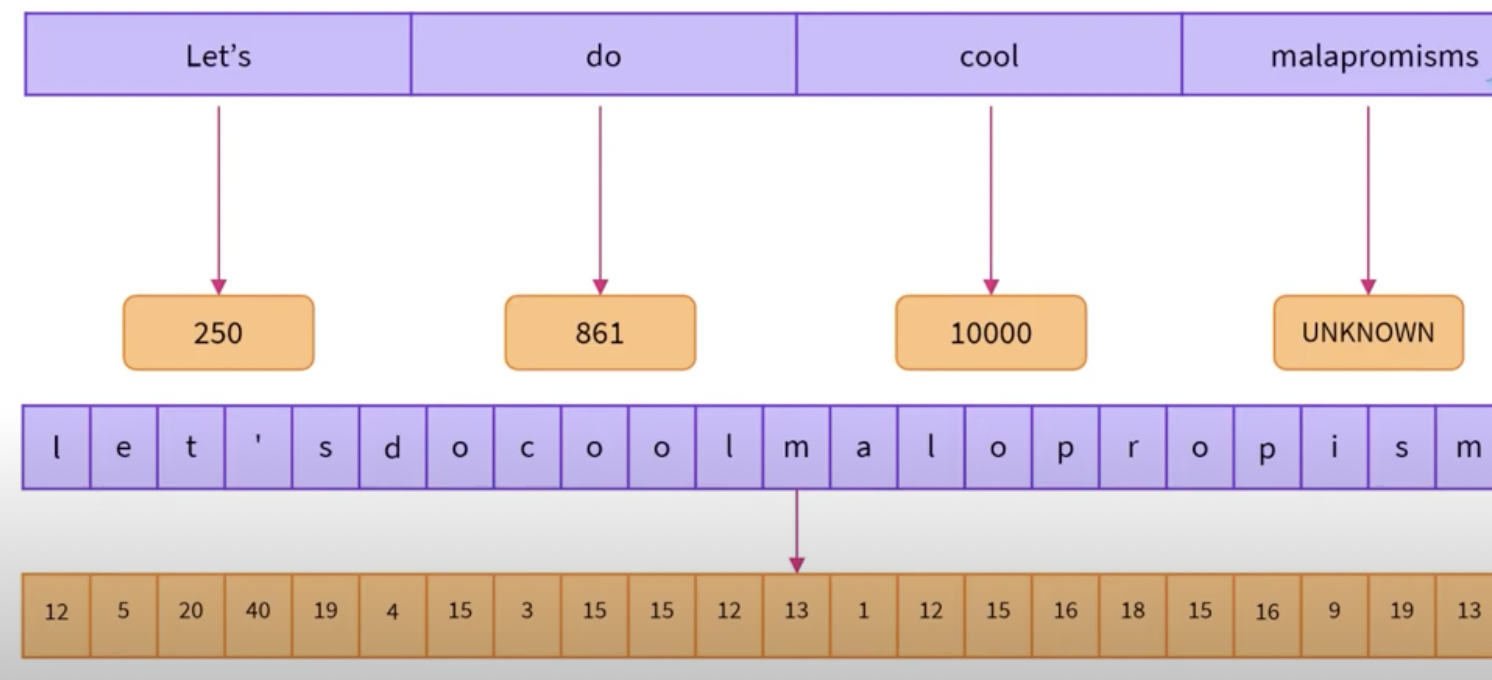

Since the representation is now based on characters rather than words, one could argue that, intuitively, it’s **less meaningful**: each character doesn’t mean a lot on its own, whereas that is the case with words

Another thing to consider is that we’ll end up with a very large amount of tokens to be processed by our model: whereas a word would only be a single token with a word-based tokenizer, it can easily turn into 10 or more tokens when converted into characters.

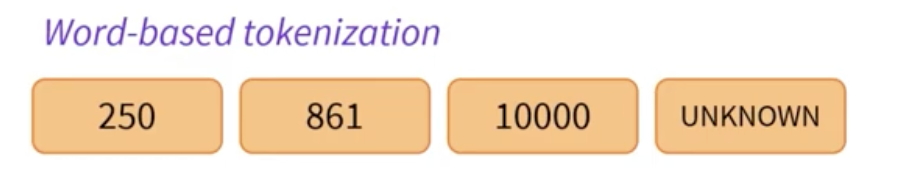

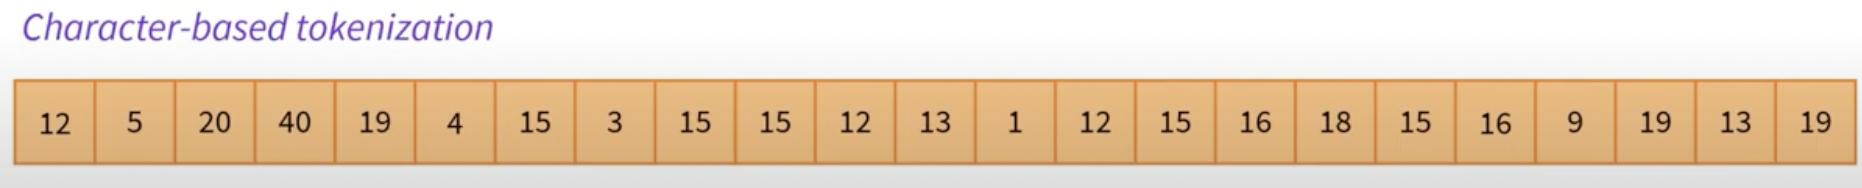

## Subword-Based Tokenizers



Subword based tokenizers find a middle ground between word and character-based algorithms.

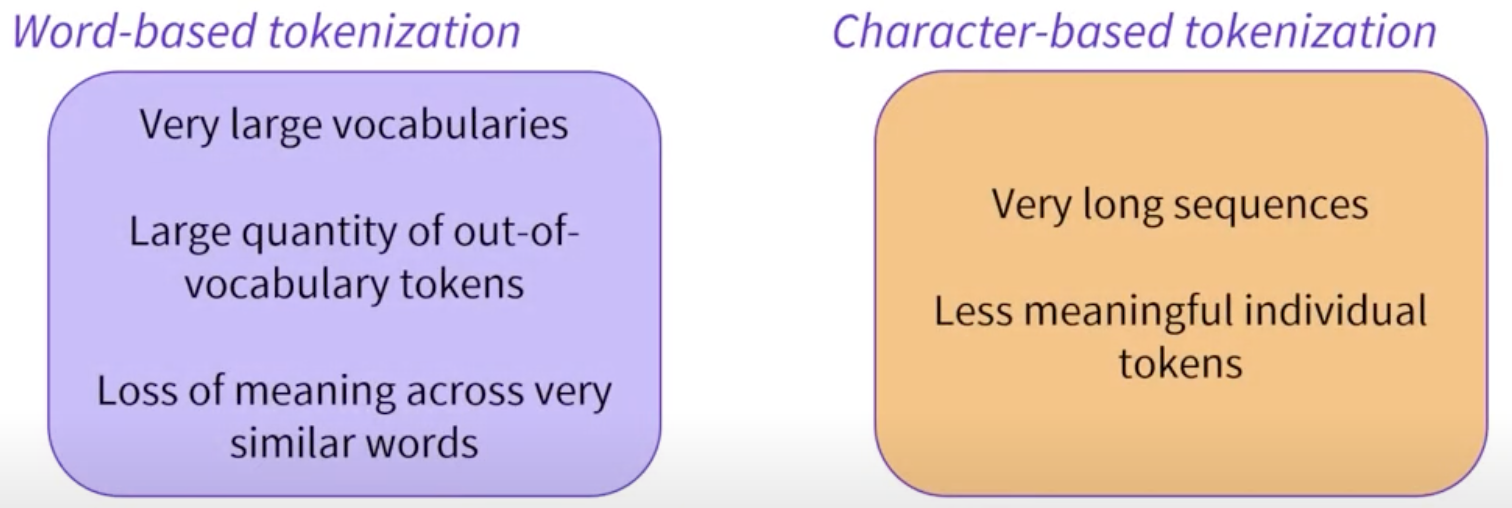

Subword tokenization algorithms rely on the principle that **frequently used words should not be split into smaller subwords**, but rare words should be decomposed into meaningful subwords.

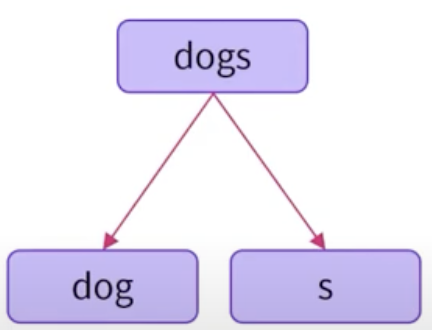

Another example:


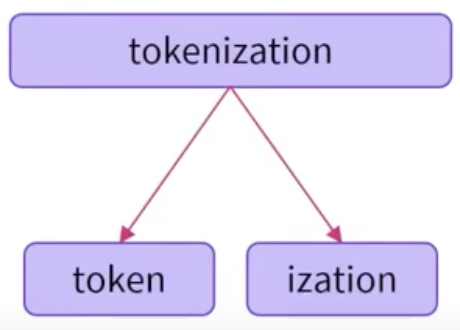

Subwords help identify similar syntactic or semantic situations in text.

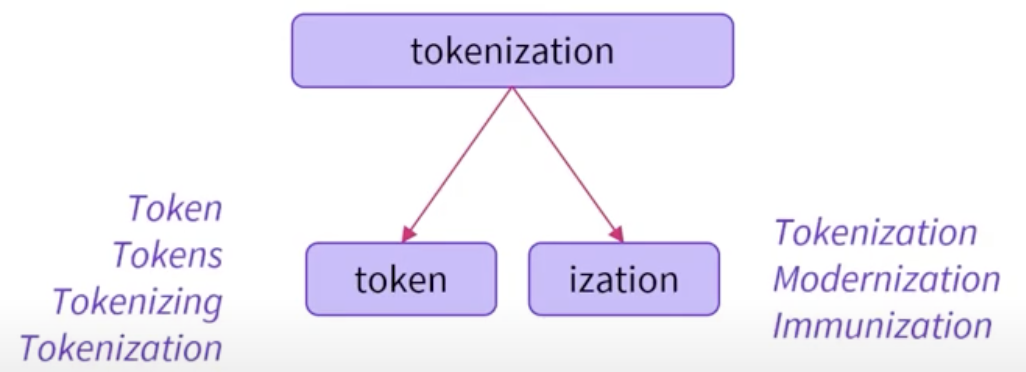

Different models have various subword tokenizer approaches:

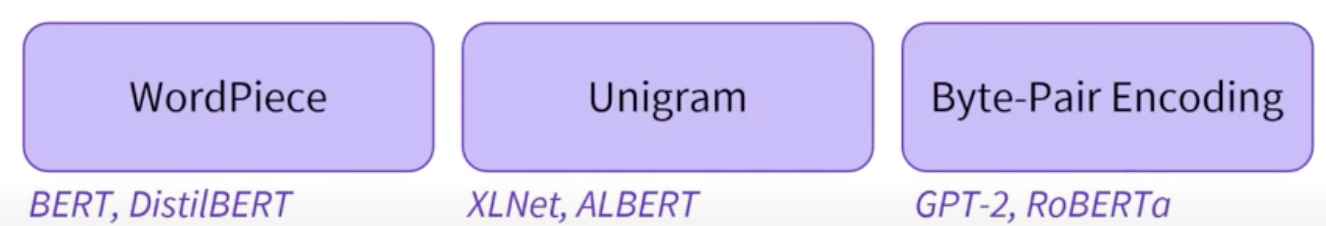

# The Tokenization Pipeline

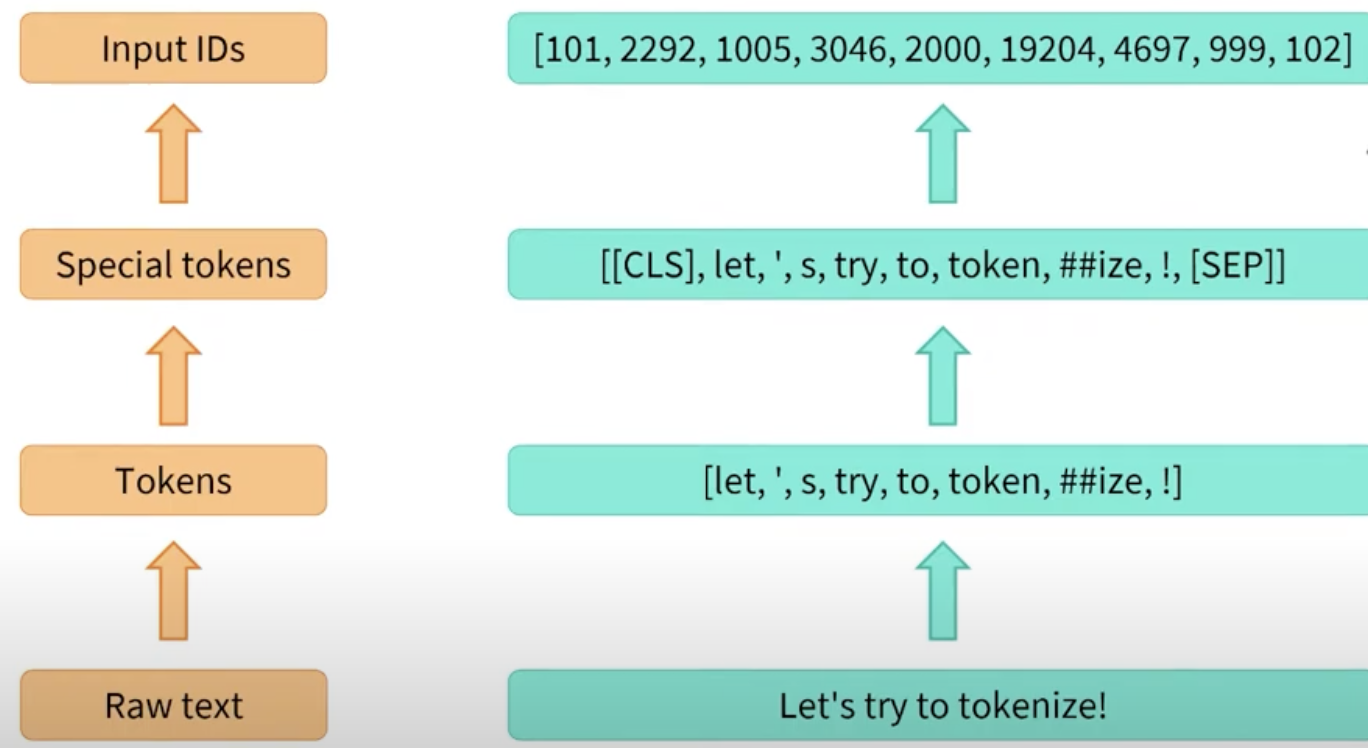

In [ ]:
# The tokenization process is done by the tokenize() method
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

sequence = "Using a Transformer network is simple"
tokens = tokenizer.tokenize(sequence)

print(tokens)

['Using', 'a', 'Trans', '##former', 'network', 'is', 'simple']


In [ ]:
# The conversion to input IDs is handled by the convert_tokens_to_ids() tokenizer method
input_ids = tokenizer.convert_tokens_to_ids(tokens)

print(input_ids)

[7993, 170, 13809, 23763, 2443, 1110, 3014]


In [ ]:
# add special tokens
final_inputs = tokenizer.prepare_for_model(input_ids)

print(final_inputs["input_ids"])

[101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102]


In [ ]:
# Decoding is going the other way around: from vocabulary indices, we want to get a string. This can be done with the decode() method
decoded_string = tokenizer.decode([7993, 170, 11303, 1200, 2443, 1110, 3014])
print(decoded_string)

Using a transformer network is simple


In [ ]:
# Decode with special tokens
decoded_string = tokenizer.decode([101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102])
print(decoded_string)

[CLS] Using a Transformer network is simple [SEP]


In [ ]:
# All together
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

sequence = "Using a Transformer network is simple"
inputs = tokenizer(sequence)

print(inputs["input_ids"])

[101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102]


In [ ]:
# Different tokenizers -> different tokens, but same code
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("albert-base-v1")

sequence = "Using a Transformer network is simple"
tokens = tokenizer.tokenize(sequence)

print(tokens)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

['▁using', '▁a', '▁transform', 'er', '▁network', '▁is', '▁simple']


## Handling multiple sequences together in the Tokenizer

In general, the sentences we want to pass to our Tokenizer won't all have the same lengths.

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sentences = ["I am in love with this!",
             "I hate this!"]

tokens = [tokenizer.tokenize(sentence) for sentence in sentences]
ids = [tokenizer.convert_tokens_to_ids(token) for token in tokens]

print(ids[0])
print(ids[1])

[1045, 2572, 1999, 2293, 2007, 2023, 999]
[1045, 5223, 2023, 999]


These two lists are of two different lengths.

Trying to create a tensor or Numpy array from the two lists will throw an error, because all arrays and tensors should be rectangular.

In [ ]:
import torch
input_ids = torch.tensor(ids)

ValueError: expected sequence of length 7 at dim 1 (got 4)

One way to overcome this is to make the second list as big as the first by adding a predefined special token as many times as needed.

This is, sometimes, called padding.

In [ ]:
ids = [[1045, 2572, 1999, 2293, 2007, 2023, 999],
       [1045, 5223, 2023, 999,     0,    0,   0]]

input_ids = torch.tensor(ids)

Another way would be to truncate the first sequence, but this would result in a loss of too much information.

We should only truncate sentences when they are larger than the sequence length the model can handle.

The value you use a special token to pad your sentences should never be random. In fact, different models have different padding token already defined.

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer.pad_token_id

0

After padding your sentences, you can finally send it to your model for prediction.

In [ ]:
from transformers import AutoModelForSequenceClassification

ids1 = torch.tensor([[1045, 2572, 1999, 2293, 2007, 2023, 999]])
ids2 = torch.tensor([[1045, 5223, 2023, 999]])

all_ids = torch.tensor([[1045, 2572, 1999, 2293, 2007, 2023, 999],
       [1045, 5223, 2023, 999,     0,    0,   0]])

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
print(model(ids1).logits)
print(model(ids2).logits)
print(model(all_ids).logits)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


tensor([[-3.7695,  4.0956]], grad_fn=<AddmmBackward0>)
tensor([[ 3.6696, -3.0004]], grad_fn=<AddmmBackward0>)
tensor([[-3.7695,  4.0956],
        [ 3.6861, -3.0049]], grad_fn=<AddmmBackward0>)


Notice that you don't get the same results for the sentence that is padded.

This is because the model's attention layers take the padding tokens as context.


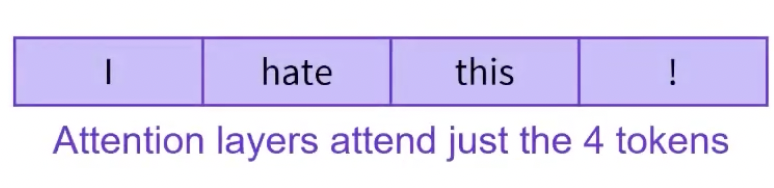

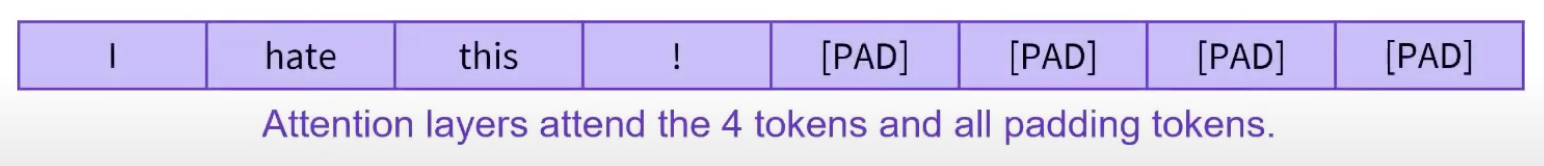

To correct for this, we have to pass an attention mask along with the input ids.

The attention mask tells the attention layers to ignore those padding tokens.

In [ ]:
all_ids = torch.tensor([[1045, 2572, 1999, 2293, 2007, 2023, 999],
                        [1045, 5223, 2023, 999,     0,    0,   0]])

attention_mask = torch.tensor([
    [1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 0, 0, 0]])

# Now we get the same output
print(model(ids1).logits)
print(model(ids2).logits)
print(model(all_ids, attention_mask=attention_mask).logits)

tensor([[-3.7695,  4.0956]], grad_fn=<AddmmBackward0>)
tensor([[ 3.6696, -3.0004]], grad_fn=<AddmmBackward0>)
tensor([[-3.7695,  4.0956],
        [ 3.6696, -3.0004]], grad_fn=<AddmmBackward0>)


All this is done by the tokenizer already behind the scenes.

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sentences = ["I am in love with this!",
             "I hate this!"]

print(tokenizer(sentences, padding=True))

{'input_ids': [[101, 1045, 2572, 1999, 2293, 2007, 2023, 999, 102], [101, 1045, 5223, 2023, 999, 102, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0]]}
